<a href="https://colab.research.google.com/github/Yenlowang/AFI/blob/master/ShortRate_lecture_final_23Marzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Curva a tiempo 0 y LGM Curve**

In [0]:
import numpy as np
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.pyplot as plt



plt.style.use('default')

# ------------------------------------------------

# Clase Curva
class IRCurve:
  
  # CONSTRUCTOR (Da vida a la clase)
  def __init__(self, dates, dfs):
    self._ref_date = dates[0]
    self._dfs = dfs
    self._times = (dates - dates[0]) / 365.25
    self._rates_time = -np.log(dfs)
    self._curve = interp1d(self._times, self._rates_time, kind = 'cubic')
  
  # Devuelve B(t, T) = B(0, T) / B(0, t)
  def get_zero(self, t, T):
    B_0_T = np.exp(-self._curve((T-self._ref_date)/365.25))
    B_0_t = np.exp(-self._curve((t-self._ref_date)/365.25))
    
    return B_0_T / B_0_t
  
 # -----------------------------------------------------
 
def H(kappa, time):
  return (1 - np.exp(-kappa * time)) / kappa
  
  
# Definición de la clase LGM
class LGMCurve:

  # CONSTRUCTOR
  def __init__(self, IR_curve, kappa, sigma):
    self._curve = IR_curve
    self._kappa = kappa
    self._sigma = sigma

  # Numerario: N(t, xt)
  def numeraire(self, t, xt):

    time_to_t = (t - self._curve._ref_date) / 365.25
    ht = H(self._kappa, time_to_t)
    zeta_t = (self._sigma ** 2) * time_to_t

    exponent = ht * xt + 0.5 * (ht**2) * zeta_t

    return 1 / self._curve.get_zero(self._curve._ref_date, t) \
            * np.exp(exponent)
  
  # B(t, T, xt)
  def get_zero_x(self, t, T, xt):

    time_to_t = (t - self._curve._ref_date) / 365.25
    time_to_T = (T - self._curve._ref_date) / 365.25

    ht = H(self._kappa, time_to_t)
    hT = H(self._kappa, time_to_T)

    zeta = (self._sigma * self._sigma) * time_to_t

    df = self._curve.get_zero(t, T) 
    exponent = (hT -ht ) * xt + 0.5 * (hT * hT - ht * ht) * zeta 

    df *= np.exp(-exponent)

    return df
    
    
 # -----------------------------------------------------

# **PRUEBA CLASE CURVA y LGM Curve**

1. Probamos la función get_zero que nos devuelve Factores de descuento vistos a Value Date



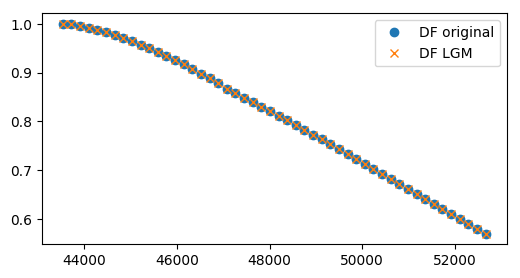

In [0]:
today = 43533
last_date = today + 365.25 * 25

# Defino las fechas pilar para los factores de desceunto ...
pillar_dates = np.linspace(today, last_date, 50)

# Defino los rates como curva no plana
dates_rates = np.array([today, today + 365, today + 365 * 5, today + 365 * 10, \
                       today +365 * 20, today + 365 * 30, today + 365 * 50])
rates = np.array([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.028])

# Calculo los FD de acuerdo a esa estructura no plana de tipos
dfs = np.zeros(len(pillar_dates))
rate_interp = interp1d(dates_rates, rates, kind = 'linear')
for i in range( len(pillar_dates)):
  rate = rate_interp(pillar_dates[i])
  dfs[i] = (np.exp(-rate * (pillar_dates[i] - today)/ 365.25))

# Definimos IR Curve (Curva original)  
ir_curve = IRCurve(pillar_dates, dfs)

# Probar funcionamiento del LGM
kappa = 0.01
sigma = 0.01
lgm_curve = LGMCurve(ir_curve, kappa, sigma )

df_lgm_at_pillar_dates = [lgm_curve.get_zero_x(today, T, 0) for T in pillar_dates]



# GENERATE GRAPH ...  
f, ax = plt.subplots()

ax.plot(pillar_dates, dfs, 'o',label = 'DF original')
ax.plot(pillar_dates, df_lgm_at_pillar_dates, 'x',label = 'DF LGM')

ax.legend()

f.set_size_inches(6, 3)


# **Prueba: Validar que el LGM cumple con el Teorema Fundamental de Valoración**

1. Simulamos el Factor de descuento a futuro de acuerdo al LGM y normalizamos path a path por el numerario.
2. Calculamos la media de estas realizaciones por fecha y comparamos contra el Factor de descuento hoy.



Means:  [0.6702282276608716, 0.6704386485524407, 0.6702235948083993, 0.6702741220626248, 0.6698732794544789, 0.670289836588832, 0.6700829465058684, 0.6696979797103987, 0.6709223402194363, 0.6697133693892345, 0.670363046781719, 0.6698439563034513, 0.6703689926529357, 0.6708346657869554, 0.6696922278446649, 0.670247203096954, 0.6704833231119826, 0.670859713385182, 0.6704251556057916, 0.6703737384582922]


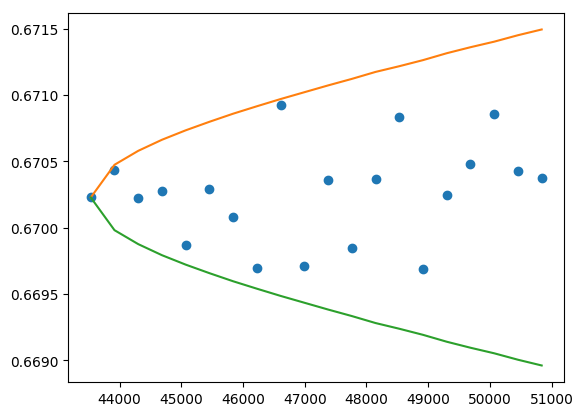

In [0]:
T = today + 20 * 365.25
simul_dates = np.linspace(today, T, 20)

nb_of_simuls = 1000000

means = []
std_dev = []

# BUCLE SIMULACIÓN ...
for date_i in simul_dates:
  
  N_0_1 = np.random.normal(size = nb_of_simuls)
  zeta_i = ((date_i - today) / 365.25)  * (sigma ** 2)
  X_at_date_i =  N_0_1 * np.sqrt(zeta_i)
  
  # Obtenemos FD con LGM B(date_i, T, x_date_i)
  B_ti_T =  lgm_curve.get_zero_x(date_i, T, X_at_date_i)
  N_ti = lgm_curve.numeraire(date_i, X_at_date_i)
  
  # FACTOR de descuento normalizado por numerario
  DF_normalized = B_ti_T / N_ti
  
  # Calculamos la media ...
  mean_ti = np.mean(DF_normalized)
  means.append(mean_ti)
  
  # Calculamos intervalo de confianza ...
  normal_percentile = sc.stats.norm.ppf(0.975)
  std = np.std(DF_normalized) / np.sqrt(nb_of_simuls) * normal_percentile
  std_dev.append(std)

print('Means: ', means)
  
# PRINT 

B0T = lgm_curve.get_zero_x(today, T, 0)
f, ax = plt.subplots()
ax.plot(simul_dates, means, 'o', label = 'Discount Factor Normalized ...')  
ax.plot(simul_dates, B0T + np.array(std_dev), '-', label = 'Upper Confidence Interval')  
ax.plot(simul_dates, B0T - np.array(std_dev), '-', label = 'Lower Confidence Interval')


## **1. Valorar Caplets de acuerdo al LGM en función del strike**

Forward libor:  0.01595895511780683
Sigma que usamos en BS 0.009458444867481042
premium [6.59624948e-02 5.80787710e-02 5.02211112e-02 4.24339069e-02
 3.48095065e-02 2.75078649e-02 2.07571398e-02 1.48188249e-02
 9.91896982e-03 6.17344328e-03 3.54723914e-03 1.87074073e-03
 9.01400215e-04 3.95493172e-04 1.57637796e-04 5.69949774e-05
 1.86777554e-05 5.54654712e-06 1.49285837e-06 3.64374960e-07]
Premium MC [6.27119139e-02 5.52388008e-02 4.77881618e-02 4.03957909e-02
 3.31669057e-02 2.62198284e-02 1.97652058e-02 1.40923948e-02
 9.46171583e-03 5.93993266e-03 3.46608271e-03 1.85938475e-03
 9.16227546e-04 4.07584333e-04 1.64733106e-04 5.90902351e-05
 1.78459381e-05 5.05648939e-06 1.59319299e-06 3.92415200e-07]


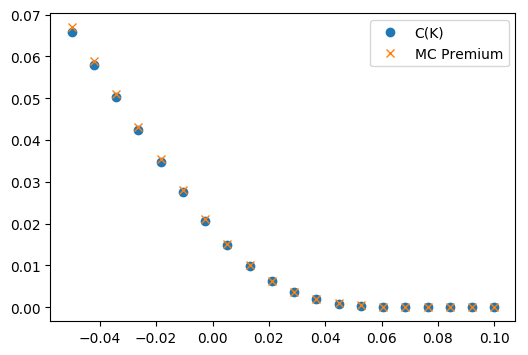

In [0]:

from scipy.stats import norm

# ----------------------------------------- | ----------

# BLACK SCHOLES ..
def LN_BlackScholes(S0, K, T, sigma):
  d1 = (np.log(S0/K) + 0.5 *  (sigma**2) * T )/(np.sqrt(T) * sigma)
  d2 = d1 - sigma * np.sqrt(T)
  
  return S0 * norm.cdf(d1) - K * norm.cdf(d2) 

def LN_BlackScholes_put(S0, K, T, sigma):
  d1 = (np.log(S0/K) + 0.5 *  (sigma**2) * T )/(np.sqrt(T) * sigma)
  d2 = d1 - sigma * np.sqrt(T)
  
  return -S0 * norm.cdf(-d1) + K * norm.cdf(-d2) 



# ----------------------------------------- | ----------


# Definimos IR Curve (Curva original)  
ir_curve = IRCurve(pillar_dates, dfs)

# Parámetros del LGM
kappa = 0.01
sigma = 0.01  # SIGMA del proceso X
lgm_curve = LGMCurve(ir_curve, kappa, sigma )

# Definimos características del caplet ...
mty_date = today + 5 * 365.25                   # t_j
pymt_date = mty_date + 365                      # t_j_1
Delta = (pymt_date - mty_date) / 360.0

libor_today = (ir_curve.get_zero(today, mty_date) / ir_curve.get_zero(today, pymt_date) \
               - 1)/ Delta
print('Forward libor: ', libor_today)

# Calcular el precio para varios K de acuerdo al LGM ---------

# 1. Calcular volatilidad de BS ...
time_to_mty_date  = (mty_date - today) / 365.25
time_to_pymt_date = (pymt_date - today) / 365.25

sigma_BS = sigma * (H(kappa, time_to_pymt_date) - \
                    H(kappa, time_to_mty_date))

print('Sigma que usamos en BS', sigma_BS)

# Definimos rango de strikes
lower_bound = -0.05
upper_bound = 0.1
number_of_strikes = 20
K = np.linspace(lower_bound, upper_bound, number_of_strikes)

# Calculamos el C(K) bajo el LGM
premium = LN_BlackScholes(libor_today + 1.0 / Delta, K + 1.0/ Delta, \
                          (mty_date - today) / 365.25, sigma_BS)

# Grafico las primas en función del strike ...
f, ax = plt.subplots()
ax.plot(K, premium, 'o', label = 'C(K)')

print('premium', premium)


# ---> Valoración de los caplets por MC

# 1. Simulamos la x hasta mty ...
nb_simul = 10000
x_at_mty = np.random.normal(size = nb_simul) * \
              sigma * np.sqrt(time_to_mty_date) 

# 2. Evaluamos el pay-off normalizado por el numerario
#    a vencimiento (L-K)^+ Delta

# 2.1 Libor a fecha de mty date
libor_at_mty_date = (1.0 / lgm_curve.get_zero_x(mty_date, pymt_date, \
                                                x_at_mty)-1)/Delta

# 2.2 Calculamos el numerario a la fecha de pago
x_at_pymt_date = x_at_mty + np.random.normal(size = nb_simul) * \
                            sigma * np.sqrt(time_to_pymt_date - time_to_mty_date)
                            
numeraire_at_pymt_date = lgm_curve.numeraire(pymt_date, x_at_pymt_date)

# Evaluamos el payoff para cada strike
premium_MC = np.zeros(len(K))
for i in range(len(K)):
  
  payoff_normalized = np.maximum(libor_at_mty_date - K[i], 0.0) * Delta
  payoff_normalized /= numeraire_at_pymt_date
  
  mean = np.mean(payoff_normalized)
  premium_MC[i] = mean


# Graficamos primas de MC para compararlas con las analíticas
df_at_pymt_date = ir_curve.get_zero(today, pymt_date)
ax.plot(K, premium_MC / df_at_pymt_date, 'x', label = 'MC Premium')
  
  
ax.legend()
f.set_size_inches(6, 4)

print('Premium MC', premium_MC)  
  

**Calculamos la función de densidad del libor a partir de precios de Caplets**

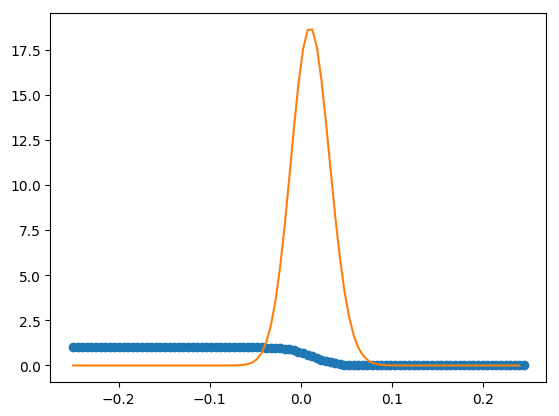

In [0]:
lower_bound = -0.25
upper_bound = 0.25
K = np.linspace(lower_bound, upper_bound, 100)

# Calculamos el C(K) bajo el LGM
premium = LN_BlackScholes(libor_today + 1.0 / Delta, K + 1.0/ Delta, \
                          (mty_date - today) / 365.25, sigma_BS)

dK = K[1] - K[0]

# Calculamos la 1a derivada dC(K)dK = [C(K + dK) - C(k)] / dK
der_right = (premium[1:]-premium[0:-1]) / dK


f, ax = plt.subplots()
ax.plot(K[0:-1], -der_right, 'o', label = 'Derivada de C(K)')

# Calculamos la función de densidad ..
second_der = (premium[0:-2] - 2 * premium[1:-1] + premium[2:]) / (dK**2)
ax.plot(K[0:-2], second_der, '-', label = 'Density function')


**Invertimos las primas del caplet para sacarnos el smile de Volatilidad** 

[0.44698125 0.4176596  0.39293868 0.37173626 0.35329705 0.33707532
 0.32266539 0.30975847 0.29811471 0.28754458 0.27789603 0.26904545
 0.2608912  0.2533488  0.24634739 0.23982704 0.23373665 0.22803237
 0.22267632 0.21763558]


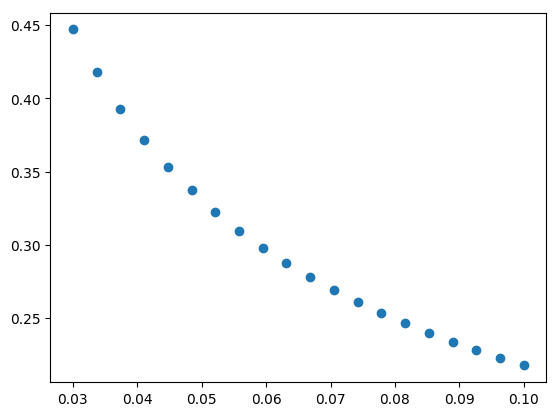

In [0]:
from scipy import optimize


lower_bound = 0.03
upper_bound = 0.1
K = np.linspace(lower_bound, upper_bound, 20)

# Calculamos el C(K) bajo el LGM
premium = LN_BlackScholes(libor_today + 1.0 / Delta, K + 1.0/ Delta, \
                          (mty_date - today) / 365.25, sigma_BS)

implicit_vols = np.zeros(len(K))
for i in range(len(K)):
  
  premium_lgm = premium[i]
  
  f_obj = lambda vol_BS : LN_BlackScholes(libor_today , K[i] , \
                                          (mty_date - today) / 365.25, vol_BS) - premium_lgm
  
  implicit_vols[i] = optimize.newton(f_obj, .25)
  

  
print(implicit_vols)
  
# Graficamos el smile de volatilidad
f, ax = plt.subplots()
ax.plot(K, implicit_vols, 'o', label = 'Smile de volatilidad (LGM)')



## **2. Valorar IRS de acuerdo al LGM** 

![texto alternativo](https://docs.google.com/a/bbva.com/drawings/d/e/2PACX-1vRbaWl-u8mzZt3u8xsCl-f6GKaTMlz_wBIR4Qft036A-OzLeFHtNboK3arMQfaDb7wSQ_C1dbOxi_1I/pub?w=960&h=720)

1. Creamos clase de definición IRS
2. Función que valora el IRS de acuerdo a LGM

In [0]:
today = 43547 # 23/3/2019
last_date = today + 365.25 * 25

# Defino las fechas pilar para los factores de desceunto ...
pillar_dates = np.linspace(today, last_date, 50)

# Defino los rates como curva no plana
dates_rates = np.array([today, today + 365, today + 365 * 5, today + 365 * 10, \
                       today +365 * 20, today + 365 * 30, today + 365 * 50])
rates = np.array([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.028])

# Calculo los FD de acuerdo a esa estructura no plana de tipos
dfs = np.zeros(len(pillar_dates))
rate_interp = interp1d(dates_rates, rates, kind = 'linear')
for i in range( len(pillar_dates)):
  rate = rate_interp(pillar_dates[i])
  dfs[i] = (np.exp(-rate * (pillar_dates[i] - today)/ 365.25))

# Definimos IR Curve (Curva original)  
ir_curve = IRCurve(pillar_dates, dfs)

# Probar funcionamiento del LGM
kappa = 0.01
sigma = 0.005
lgm_curve = LGMCurve(ir_curve, kappa, sigma )



In [0]:

# CLASE IRS
class IRS:
  
  def __init__(self, start_date, tenor, freq, fixed_coupon):
    self.start_date = start_date
    self.end_date = start_date + tenor * 365.25   ###
    self.fix_dates = np.linspace(self.start_date, self.end_date, tenor * freq) 
    self.fixed_coupon = fixed_coupon
    self.dcf = (self.fix_dates[1:] - self.fix_dates[0:-1])/360 # Act/360
    self.fix_dates = self.fix_dates[1:]


    
# Función que valora el IRS de acuerdo al LGM
def LGM_IRS_price(value_date, irs, lgm_curve, x_at_value_date):
  
  # Pata Flotante
  floating_leg = lgm_curve.get_zero_x(value_date, irs.start_date, x_at_value_date) - \
                 lgm_curve.get_zero_x(value_date, irs.end_date, x_at_value_date) 
    
  # Pata Fija
  fixed_leg = 0
  for i in range(len(irs.fix_dates)):
    fixed_leg += irs.dcf[i] * lgm_curve.get_zero_x(value_date, \
                                                   irs.fix_dates[i], x_at_value_date)
  
  fixed_leg *= irs.fixed_coupon
  
  return (floating_leg - fixed_leg)


# Función de valoración del swaption
def LGM_Swaption_Price(value_date, irs, lgm_curve):
  
  # 1. Calculamos x_star tal que IRS(T, x_star) = 0 
  T_mat = irs.start_date
  f_obj = lambda x : LGM_IRS_price(T_mat, irs, lgm_curve, x)
  x_star = optimize.newton(f_obj, 0)
  
  # Función anidada que calcula la put sobre ZC -------------
  def ZC_put(T_j):
    # Valoramos la última put sobre ZC
    fwd = lgm_curve.get_zero_x(value_date, T_j, 0) / \
          lgm_curve.get_zero_x(value_date, irs.start_date, 0)

    # strike B(T, T_N, x_star)
    strike = lgm_curve.get_zero_x(irs.start_date, T_j, x_star)

    # vol = (H_T - H_T_N) sigma_x
    vol = H(lgm_curve._kappa, (irs.start_date - value_date) / 365.25) - \
          H(lgm_curve._kappa, (T_j - value_date) / 365.25)
    
    vol *= lgm_curve._sigma
    
    vol = np.abs(vol)

    # Llamamos BS
    last_put = LN_BlackScholes_put(fwd, strike, \
                               (irs.start_date - value_date)/365.25, vol)
    #last_put = last_call - (fwd - strike)
    
    return last_put
  # ------------------------------------------------------------
  
  # Iteramos por todas las fechas de pago del IRS y calculamos \
  # las puts sobre los ZC.
  
  swaption = 0 
  for i in range(len(irs.fix_dates)):
    # Calculate put
    put = ZC_put(irs.fix_dates[i])
    
    # Calculate K Delta o (1 + K Delta)
    notional = irs.dcf[i] * irs.fixed_coupon
    
    #if i == len(irs.fix_dates):
    if i == len(irs.fix_dates)-1:
      notional += 1 
      
    # Actualizamos el precio del swaption
    swaption += notional * put
  
  return swaption
  
  
# ---------------------------------------------------------------
  
# prueba de la clase
T = today + 365.25 * 10
irs = IRS(T, 10, 2, 0.0246)

# Probamos la clase pricer de swaption
swaption_premium = LGM_Swaption_Price(today, irs, lgm_curve)

print('Swaption premium', swaption_premium)


# CUADRE POR SIMULACIÓN MC ....
x_at_T = np.random.normal(size = 10000000) * lgm_curve._sigma * \
            np.sqrt((T - today) / 365.25)





irs_at_T = LGM_IRS_price(T, irs, lgm_curve, x_at_T)



irs_at_T /= lgm_curve.numeraire(T, x_at_T)


premium_MC = np.mean(np.maximum(irs_at_T,0))/ ir_curve.get_zero(today, T) 

#premium_MC = np.mean(irs_at_T)/ ir_curve.get_zero(today, T) 

print('Swaption premium MC', premium_MC)


Swaption premium 0.04865586028252534
Swaption premium MC 0.048651388451584836


In [0]:
premium_MC/swaption_premium

0.9999080926549333

In [0]:
H(lgm_curve._kappa, (irs.fix_dates[0] - today) / 365.25)

9.991237374774064

In [0]:
np.mean(irs_at_T_plus)

NameError: ignored

In [0]:
H(0.01,0)

0.0

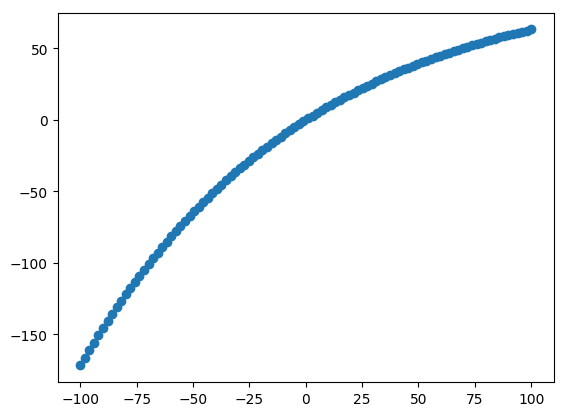

In [0]:
plt.plot(np.linspace(-100,100,100),H(0.01,np.linspace(-100,100,100)),'o')

In [0]:
lgm_curve = LGMCurve(ir_curve, kappa, sigma )

In [0]:
  # Pata Flotante
  floating_leg = lgm_curve.get_zero_x(today, irs.start_date, 0) - \
                 lgm_curve.get_zero_x(today, irs.end_date, 0) 
    
  # Pata Fija
  fixed_leg = 0
  for i in range(len(irs.fix_dates)):
    fixed_leg += irs.dcf[i] * lgm_curve.get_zero_x(today, \
                                                   irs.fix_dates[i], 0)
  
  fixed_leg 
  
  floating_leg / fixed_leg

In [0]:
lgm_curve._sigma